In [6]:
pip install requests

  Using cached requests-2.26.0-py2.py3-none-any.whl (62 kB)
  Using cached urllib3-1.26.7-py2.py3-none-any.whl (138 kB)
  Using cached charset_normalizer-2.0.7-py3-none-any.whl (38 kB)



In [1]:
import json
import requests
import os
import urllib
from rdkit import Chem
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem import Graphs
from rdkit.Chem import rdmolops
from rdkit.Chem import Draw
# with CoordGen
from rdkit.Chem import rdCoordGen
from rdkit.Chem.Draw import MolDrawing, DrawingOptions

In [2]:
IPythonConsole.drawOptions.addAtomIndices = True #индексируем атомы

In [3]:
url = 'https://bitbucket.org/sib-pig/rban/raw/0190ed2f49d6e52d8454f7e99add24a715ece4aa/src/main/resources/molecules/monomer/nrproMonomers.json'
response = requests.get(url)

monomers = json.loads(response.text)
#response.raise_for_status()  # raises exception when not a 2xx response
#if response.status_code != 204:
 #   print(response.text)
  #  monomers = json.loads(response)

In [4]:
#Можно раскомментировать, чтобы убедиться что это json
#monomers

In [5]:
monomers_dict = {}
for mon in monomers:
    monomers_dict[mon['monomer']] = mon['smiles'] 

In [10]:
#Вывод словаря
#print(monomers_dict)

In [11]:
monomers_dict['Phe'] #проверка,что в словаре есть нужные аминокислоты

'NC(Cc1ccccc1)C(=O)O'

Пока что разбираем граф из примера:

In [20]:
m1 = Chem.MolFromSmiles(monomers_dict['Phe'])

In [21]:
m2 = Chem.MolFromSmiles(monomers_dict['Ser'])

In [22]:
m3 = Chem.MolFromSmiles(monomers_dict['Cl2-Pro'])

In [23]:
m4 = Chem.MolFromSmiles(monomers_dict['Abu'])

In [24]:
m5 = Chem.MolFromSmiles(monomers_dict['Ser'])

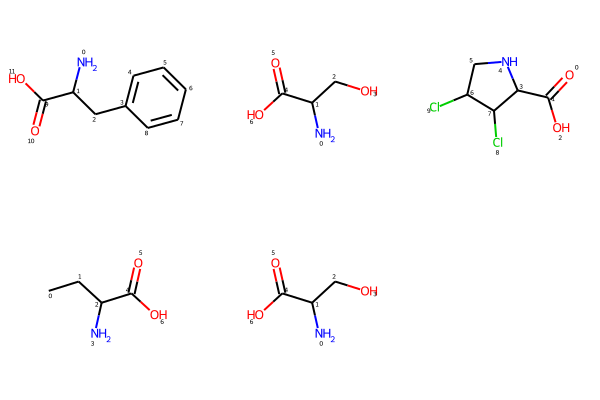

In [25]:
MolsToGridImage((m1, m2, m3, m4, m5)) #так выглядят молекулы, которые надо склеить

In [18]:
def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol

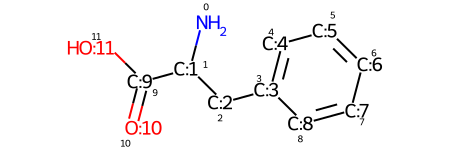

In [19]:
mol_with_atom_index(m1)

# Попытка №1: соединим 1 и 3 молекулу

In [33]:
part_O_C_OH = Chem.MolFromSmarts('C(=O)O')#O=C-OH 
m1.GetSubstructMatches(part_O_C_OH)

((9, 10, 11),)

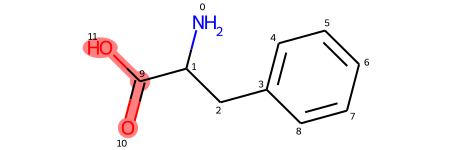

In [34]:
m1#выделили alpha-карбоксильную группу в первой молекуле

In [35]:
without_radical = Chem.MolFromSmiles('NCC(=O)O')#NH2_C_C_O_OH
m1.GetSubstructMatches(without_radical)

((0, 1, 9, 10, 11),)

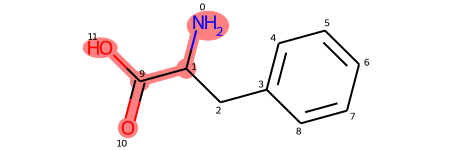

In [36]:
m1#Выделили alpha-карбоксильную и alpha-аминогруппу

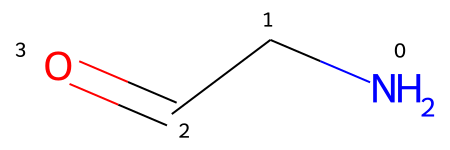

In [37]:
without_OH = Chem.MolFromSmiles('NCC(=O)')#NH2-C-C=O
without_OH

In [38]:
m3.GetSubstructMatches(without_radical)

((4, 3, 1, 0, 2),)

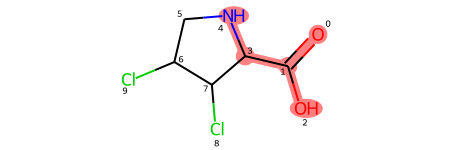

In [39]:
m3

Кортежи, которые мы получили выглядят так, будто перечисление индексов в выделенных областях происходит в одном и том же порядке

In [42]:
m3.GetSubstructMatches(without_radical)[0][4] #смотрим на часть без радикала и берем -OH

2

In [43]:
mw3 = Chem.RWMol(m3)

In [45]:
mw3.RemoveAtom(m3.GetSubstructMatches(without_radical)[0][4])#удаляем -OH

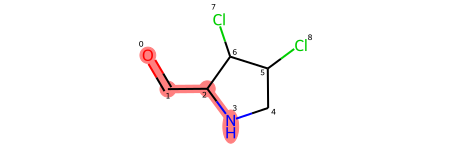

In [48]:
mw3

In [49]:
mw3.GetSubstructMatches(without_OH)#посмотрим как выглядит кортеж после удаления OH

((3, 2, 1, 0),)

Нумерация поменялась(((((((

In [52]:
mw3.GetSubstructMatches(without_OH)[0][2] #этот элемент кортежа надо соединить с первой молекулой

1

In [54]:
combo = Chem.CombineMols(m1,mw3)

In [55]:
edcombo = Chem.EditableMol(combo)

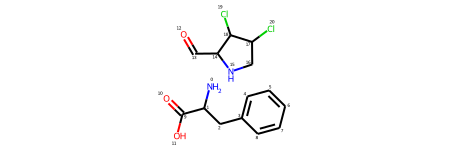

In [56]:
combo#тут снова происходит перераспределение индексов.....

In [57]:
edcombo.AddBond(0,13,order=Chem.rdchem.BondType.SINGLE)#надо соединять 0 и 13 атом, судя по рисунку выше

22

In [58]:
back = edcombo.GetMol()#соединяем

In [103]:
back2 = Chem.MolToSmiles(back)
back2

'O=C(O)C(Cc1ccccc1)NC(=O)C1NCC(Cl)C1Cl'

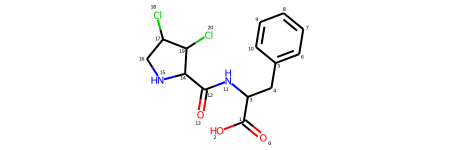

In [104]:
Chem.MolFromSmiles(back2)